In [36]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import lstsq
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from ctf_dataset.load import create_wrapped_dataset
from behavior_heuristics import has_opponent_flag

In [2]:
base_dir = '/jukebox/hasson/snastase/social-ctf'
data_dir = join(base_dir, 'data_v1')
wrap_f = create_wrapped_dataset(data_dir, output_dataset_name="virtual_v2.hdf5")

sns.set(context='notebook', style='white')
palette = sns.color_palette(['.65', 'darkgoldenrod'])

In [3]:
action_labels = {'look left/right': [0., 1., 2., 3., 4.],
                 'look up/down': [0., 1., 2.],
                 'strafe left/right': [0., 1., 2.],
                 'move backward/forward': [0., 1., 2.],
                 'fire or switch': [0., 1., 2., 3.],
                 'jump': [0., 1.]}

n_subactions = len(np.concatenate(list(action_labels.values())))
assert n_subactions == 20

# Function for expanding 6 action channels into 20 subactions
def expand_actions(actions, action_labels):
    
    subactions = {}
    for a, label in enumerate(action_labels):
        
        # Expand look left/right into five separate actions
        subactions[label] = np.zeros((actions.shape[:-1] +
                                      (len(action_labels[label]),)))
        for subaction in action_labels[label]:
            subactions[label][..., int(subaction)][
                actions[..., a] == subaction] = 1
        
        # Check that each subaction occurs uniquely in time
        #assert np.all(np.sum(subactions[label], axis=1) == 1)
        
    subactions = np.concatenate([subactions[a] for a in subactions],
                                axis=-1)
    #assert np.array_equal(np.unique(b), np.array([0, 1]))
            
    return subactions

In [4]:
def stack_behaviors(player_id, map_id=slice(None), 
                    matchup_id=0, repeat_id=slice(None)):
    
    
    # health: 1 value
    # position: 2 x, y values
    # direction: 4 sin/cos values (from 2 angles)
    # velocity: 2 x, y values
    # has flag: 1 value
    # actions: 20 one-hot values (from 6 actions)
    # total: 30 behavior variables

    behav_labels = ['health', 'position', 'direction', 'velocity']

    player_behav = []

    # Loop through simple behaviors/relations
    for behav_label in behav_labels:
        behav = wrap_f[f'map/matchup/repeat/player/time/{behav_label}'][
            map_id, matchup_id, repeat_id, player_id][..., :2]

        if behav_label == 'direction':
            behav = np.concatenate((np.sin(np.radians(behav)),
                                    np.cos(np.radians(behav))),
                                   axis=-1)

        player_behav.append(behav)

    # Extract whether has opponent flag  
    has_flag = has_opponent_flag(wrap_f, map_id=map_id, matchup_id=matchup_id,
                                 repeat_id=repeat_id, player_id=player_id,
                                 min_behavior_length=0)
    player_behav.append(has_flag)

    # Extract action outputs
    actions = wrap_f[f'map/matchup/repeat/player/time/action'][
                     map_id, matchup_id, repeat_id, player_id]
    actions_1hot = expand_actions(actions, action_labels)
    player_behav.append(actions_1hot)

    return np.concatenate(player_behav, axis=-1)

In [785]:
behav_labels = (['health'] + ['position'] * 2 +
                ['direction'] * 4 + ['velocity'] * 2 +
                ['has flag'] +
                ['look left/right'] * 5 +
                ['look up/down'] * 3 +
                ['strafe left/right'] * 3 +
                ['move backward/forward'] * 3 +
                ['fire or switch'] * 4 +
                ['jump'] * 2)
assert len(behav_labels) == 30

In [455]:
def mediation_encoding(train_X, test_X,
                       train_Y, test_Y,
                       train_M, test_M,
                       scorer=r2_score):
    
    X_width = train_X.shape[-1]
    
    train_X_int = np.column_stack((train_X, np.ones(train_X.shape[0])))
    test_X_int = np.column_stack((test_X, np.ones(test_X.shape[0])))
    
    W, _, _, _ = lstsq(train_X_int, train_Y, rcond=None)
    pred_total = test_X_int @ W
    
    W, _, _, _ = lstsq(train_X_int, train_M, rcond=None)
    pred_M = test_X_int @ W
    
    train_XM = np.column_stack((train_X, train_M, np.ones(train_X.shape[0])))
    test_XM = np.column_stack((test_X, test_M, np.ones(test_X.shape[0])))
    
    W, _, _, _ = lstsq(train_XM, train_Y, rcond=None)
    pred_medi = test_XM @ W
    
    W_direct = np.zeros(W.shape)
    W_direct[:X_width] = W[:X_width]
    W_direct[-1] = W[-1]
    pred_direct = test_XM @ W_direct
    
    def get_score(actual, predicted):
        if scorer is pearsonr:
            score = pearsonr(actual, predicted)[0]
        else:
            score = scorer(actual, predicted)
        return score

    scores_total, scores_M, scores_medi = [], [], []
    scores_direct = []
    for t in np.arange(test_Y.shape[1]):
        scores_total.append(
            get_score(pred_total[:, t], 
                      test_Y[:, t]))
        scores_M.append(
            get_score(pred_M, 
                      test_M))
        scores_medi.append(
            get_score(pred_medi[:, t], 
                      test_Y[:, t]))
        scores_direct.append(
            get_score(pred_direct[:, t], 
                      test_Y[:, t]))
    
    return scores_total, scores_M, scores_medi, scores_direct

In [184]:
def autoreg_encoding(train_X, test_X,
                     train_Y, test_Y,
                     train_future, test_future,
                     scorer=r2_score):
    
    train_auto = np.column_stack((train_Y, np.ones(train_Y.shape[0])))
    test_auto = np.column_stack((test_Y, np.ones(test_Y.shape[0])))
    
    W, _, _, _ = lstsq(train_auto, train_future, rcond=None)
    pred_auto = test_auto @ W
    
    train_causal = np.column_stack((train_X, train_Y))
    test_causal = np.column_stack((test_X, test_Y))
    
    train_causal = np.column_stack((train_causal, np.ones(train_causal.shape[0])))
    test_causal = np.column_stack((test_causal, np.ones(test_causal.shape[0])))
    
    W, _, _, _ = lstsq(train_causal, train_future, rcond=None)
    pred_causal = test_causal @ W
    
    def get_score(actual, predicted):
        if scorer is pearsonr:
            score = pearsonr(actual, predicted)[0]
        else:
            score = scorer(actual, predicted)
        return score

    scores_auto, scores_causal = [], []
    for t in np.arange(test_future.shape[1]):
        scores_auto.append(
            get_score(pred_auto[:, t], 
                      test_future[:, t]))
        scores_causal.append(
            get_score(pred_causal[:, t], 
                      test_future[:, t]))
    
    return scores_auto, scores_causal

In [11]:
# Load up and stack behaviors for player, teammate, and opponent
n_players = 4
map_id, matchup_id, repeat_id = slice(None), 0, 0

player_teammate = {0: 1, 1: 0, 2: 3, 3: 2}

player_behav, teammate_behav = [], []
for player_id in np.arange(n_players):
    player_behav.append(stack_behaviors(
        player_id, map_id=map_id,
        matchup_id=matchup_id, repeat_id=repeat_id))
    teammate_behav.append(stack_behaviors(
        player_teammate[player_id], map_id=map_id,
        matchup_id=matchup_id, repeat_id=repeat_id))

player_behav = np.stack(player_behav, -3)
teammate_behav = np.stack(teammate_behav, -3)

In [ ]:
# Load train/test PCA folds
n_maps = 32
n_repeats = 32
n_players = 4
n_samples = 4501
n_lstms = 512
n_pcs = 142
n_targets = 30

map_id = slice(None)
matchup_id = 0
repeat_id = 0
player_id = slice(None)

M_offset = 1
Y_offset = M_offset + 150

pc_scores = {'total score': [], 'XM score': [], 'mediation score': [],
             'direct score': [], 'behavior': [],
             'PC': [], 'test map': [], 'player': []}

for test_map in np.arange(n_maps):
    train_maps = np.array([m for m in np.arange(n_maps) if m != test_map])

    train_repeats = np.tile(np.repeat(np.arange(n_repeats), n_players * n_samples), n_maps - 1)
    test_repeats = np.repeat(np.arange(n_repeats), n_players * n_samples)

    train_shape = ((n_maps - 1) * n_repeats * n_players * n_samples, n_lstms)
    test_shape = (n_repeats * n_players * n_samples, n_lstms)

    assert train_shape[0] == train_repeats.shape[0]
    assert test_shape[0] == test_repeats.shape[0]

    train_lstms_in = np.memmap(f'results/lstms-stack_tanh-z_cvpca-train_'
                              f'matchup-{matchup_id}_map-{test_map}.npy',
                              mode='r', dtype='float64', shape=train_shape)[
                                  train_repeats == repeat_id, :n_pcs]
    test_lstms_in = np.memmap(f'results/lstms-stack_tanh-z_cvpca-test_'
                              f'matchup-{matchup_id}_map-{test_map}.npy',
                              mode='r', dtype='float64', shape=test_shape)[
                                  test_repeats == repeat_id, :n_pcs]

    stack_train_lstms = np.stack(np.split(np.stack(np.split(
        train_lstms_in, n_maps - 1, axis=0), axis=0), n_players, axis=1), axis=1)

    stack_test_lstms = np.stack(np.split(
        test_lstms_in, n_players, axis=0), axis=0)

    #for pc_id in np.arange(n_pcs):
    for pc_id in np.arange(n_pcs):
    
        for player_id in np.arange(n_players):

            train_X = teammate_behav[train_maps, player_id]
            test_X = teammate_behav[test_map, player_id]
            train_Y = player_behav[train_maps, player_id]
            test_Y = player_behav[test_map, player_id]
            train_lstms = stack_train_lstms[:, player_id, :, pc_id]
            test_lstms = stack_test_lstms[player_id, :, pc_id]
            
            train_lstms = np.concatenate((train_lstms[..., M_offset:],
                        np.zeros((train_lstms.shape[:-1] +
                                 (M_offset,)))), axis=-1)
            test_lstms = np.concatenate((test_lstms[..., M_offset:],
                        np.zeros((test_lstms.shape[:-1] +
                                 (M_offset,)))), axis=-1)
            
            train_Y = np.concatenate((train_Y[..., Y_offset:, :],
                        np.zeros((train_Y.shape[:-2] +
                                 (Y_offset,) +
                                 (train_Y.shape[-1],)))), axis=-2)
            test_Y = np.concatenate((test_Y[..., Y_offset:, :],
                        np.zeros((test_Y.shape[:-2] +
                                 (Y_offset,) +
                                 (test_Y.shape[-1],)))), axis=-2)

            train_X = train_X.reshape((-1, train_X.shape[-1]))
            test_X = test_X.reshape((-1, test_X.shape[-1]))
            train_Y = train_Y.reshape((-1, train_Y.shape[-1]))
            test_Y = test_Y.reshape((-1, test_Y.shape[-1]))
            train_lstms = train_lstms.reshape(-1)
            test_lstms = test_lstms.reshape(-1)

            scores = mediation_encoding(train_X, test_X,
                                        train_Y, test_Y,
                                        train_lstms, test_lstms,
                                        scorer=pearsonr)
            scores_total, scores_XM, scores_medi, scores_direct = scores
            pc_scores['total score'].extend(scores_total)
            pc_scores['XM score'].extend(scores_XM)
            pc_scores['mediation score'].extend(scores_medi)
            pc_scores['direct score'].extend(scores_direct)
            pc_scores['test map'].extend([test_map] * n_targets)
            pc_scores['behavior'].extend(behav_labels)
            pc_scores['PC'].extend([pc_id] * n_targets)
            pc_scores['player'].extend([player_id] * n_targets)
        print(f"Finished PC{pc_id}, map {test_map}")
        
scores_df = pd.DataFrame(pc_scores)
scores_df.to_csv(f'results/mediation-behav_Moffset-{M_offset}_Yoffset-{Y_offset}_matchup-{matchup_id}_results.csv', index=False)

Finished PC0, map 0
Finished PC1, map 0
Finished PC2, map 0
Finished PC3, map 0
Finished PC4, map 0
Finished PC5, map 0
Finished PC6, map 0
Finished PC7, map 0
Finished PC8, map 0
Finished PC9, map 0
Finished PC10, map 0
Finished PC11, map 0
Finished PC12, map 0
Finished PC13, map 0
Finished PC14, map 0
Finished PC15, map 0
Finished PC16, map 0
Finished PC17, map 0
Finished PC18, map 0
Finished PC19, map 0
Finished PC20, map 0
Finished PC21, map 0
Finished PC22, map 0
Finished PC23, map 0
Finished PC24, map 0
Finished PC25, map 0
Finished PC26, map 0
Finished PC27, map 0
Finished PC28, map 0
Finished PC29, map 0
Finished PC30, map 0
Finished PC31, map 0
Finished PC32, map 0
Finished PC33, map 0
Finished PC34, map 0
Finished PC35, map 0
Finished PC36, map 0
Finished PC37, map 0
Finished PC38, map 0
Finished PC39, map 0
Finished PC40, map 0
Finished PC41, map 0
Finished PC42, map 0
Finished PC43, map 0
Finished PC44, map 0
Finished PC45, map 0
Finished PC46, map 0
Finished PC47, map 0
Fi

<AxesSubplot:xlabel='total score', ylabel='behavior'>

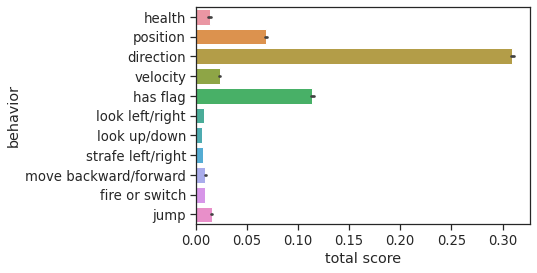

In [508]:
sns.barplot(y='behavior', x='total score', data=scores_df)

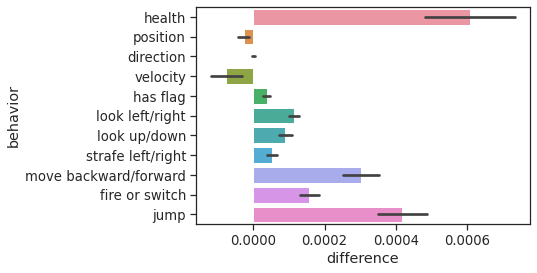

In [515]:
scores_df['difference'] = scores_df['total score'] - scores_df['direct score']

sns.barplot(y='behavior', x='difference', data=scores_df)
scores_df = scores_df.drop(columns=['difference'])

In [93]:
group_df = scores_df.groupby(['behavior', 'lag', 'test map', 'player']).mean()
group_df.mean()

direct score    0.163149
dtype: float64

<AxesSubplot:xlabel='direct score', ylabel='behavior'>

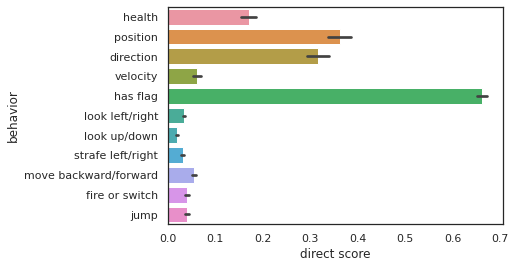

In [134]:
sns.barplot(y='behavior', x='direct score', data=scores_df)

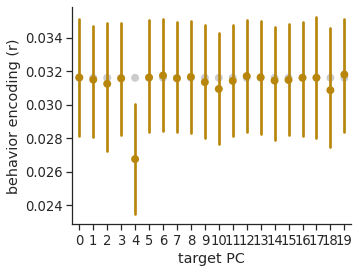

In [597]:
M_offset = 1
Y_offset = M_offset + 1
scores_df = pd.read_csv(f'results/mediation-behav_Moffset-{M_offset}_Yoffset-{Y_offset}_matchup-{matchup_id}_results.csv')

sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 4))
#fig, ax = plt.subplots(figsize=(5, 4))
sns.pointplot(x='PC', y='total score', ci=None,
              data=scores_df[(scores_df['behavior'] == 'strafe left/right') &
                             (scores_df['PC'] < 20)],
              color='.8', ax=ax, scale=.9, zorder=0, join=False)
sns.pointplot(x='PC', y='direct score',
              data=scores_df[(scores_df['behavior'] == 'strafe left/right') &
                             (scores_df['PC'] < 20)],
              color='darkgoldenrod',
              join=False, ax=ax, scale=.9)
ax.set(xlabel='target PC', ylabel='behavior encoding (r)')
#ax.set_xticks(np.insert(np.arange(20, n_pcs, 20) - 1, 0, 0))
#ax.set_xticklabels(np.insert(np.arange(20, n_pcs, 20), 0, 1))
sns.despine()

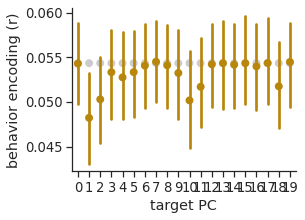

In [669]:
offset = 1
scores_df = pd.read_csv(f'results/mediation-behav_offset-{offset}_matchup-{matchup_id}_results.csv')

behavior = 'move backward/forward'
grouper = ['behavior', 'PC', 'test map', 'player']
scores_df = scores_df[scores_df['behavior'] == behavior].groupby(
    grouper, as_index=False).mean()

sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(4, 3))
#fig, ax = plt.subplots(figsize=(5, 4))
sns.pointplot(x='PC', y='total score', ci=None,
              data=scores_df[(scores_df['PC'] < 20)],
              color='.8', ax=ax, scale=.9, zorder=0, join=False)
sns.pointplot(x='PC', y='direct score',
              data=scores_df[(scores_df['PC'] < 20)],
              color='darkgoldenrod',
              join=False, ax=ax, scale=.9)
ax.set(xlabel='target PC', ylabel='behavior encoding (r)')
#ax.set_xticks(np.insert(np.arange(20, n_pcs, 20) - 1, 0, 0))
#ax.set_xticklabels(np.insert(np.arange(20, n_pcs, 20), 0, 1))
sns.despine()

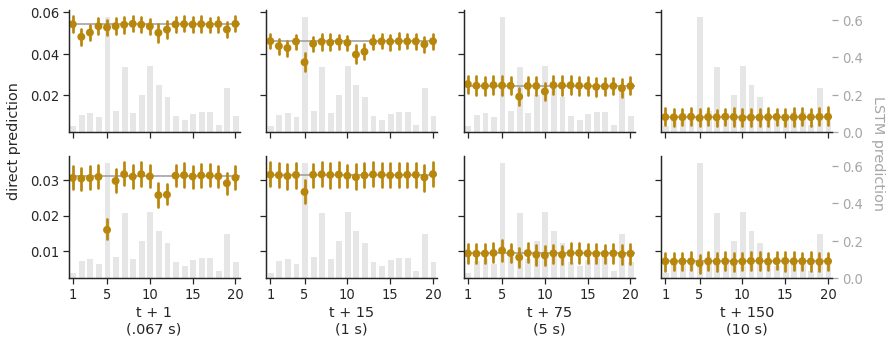

In [735]:
offsets = {1: 1/15, 15: 1, 75: 5, 150: 10}
behaviors = (['move backward/forward'] * 4 +
             ['strafe left/right'] * 4)
grouper = ['behavior', 'PC', 'test map', 'player', 'offset']
offset_labels = ['t + 1\n(.067 s)', 't + 15\n(1 s)',
                 't + 75\n(5 s)', 't + 150\n(10 s)']

scores_dfs = []
for offset in offsets:
    scores_df = pd.read_csv(f'results/mediation-behav_offset-{offset}_matchup-{matchup_id}_results.csv')
    scores_df['offset'] = offset
    scores_dfs.append(scores_df)
scores_df = pd.concat(scores_dfs)

sns.set(style='ticks', font_scale=1.2)
fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey='row')

twinaxs = []
for offset, behavior, ax in zip(list(offsets) * 2, behaviors, axs.ravel()):
    scores_dfb = scores_df[scores_df['behavior'] == behavior]#.groupby(
    #    grouper, as_index=False).mean()
    total_score = scores_dfb['total score'][
        (scores_dfb['PC'] < 20) &
        (scores_dfb['offset'] == offset)].mean()
    ax1 = ax.twinx()
    twinaxs.append(ax1)
    sns.barplot(x='PC', y='XM score', ci=None,#errcolor='.8', errwidth=.5,
                data=scores_dfb[(scores_dfb['PC'] < 20) &
                                (scores_dfb['offset'] == offset)],
                color='.9', zorder=0, ax=ax1)
    ax1.set(xlabel=None, ylabel=None, yticks=[])
    ax.axhline(total_score, c='.6', zorder=0)
    sns.pointplot(x='PC', y='direct score',
                  data=scores_dfb[(scores_dfb['PC'] < 20) &
                                  (scores_dfb['offset'] == offset)],
                  color='darkgoldenrod', zorder=1000,
                  join=False, ax=ax, scale=.9)
    ax.set(xlabel=None, ylabel=None)
    ax.set_xticks([0, 4, 9, 14, 19])
    ax.set_xticklabels([1, 5, 10, 15, 20])
    ax.set_zorder(ax1.get_zorder()+1)
    ax.patch.set_visible(False)

for c, o in enumerate(offset_labels):
    axs[1, c].set(xlabel=o)
twinaxs[3].set(yticks=[0, .2, .4, .6])
twinaxs[3].tick_params(axis='y', colors='.65')
twinaxs[7].set(yticks=[0, .2, .4, .6])
twinaxs[7].tick_params(axis='y', colors='.65')
fig.text(1, 0.4, 'LSTM prediction', c='.65',
         ha='center', rotation=270)
fig.text(0, 0.43, 'direct prediction',
         ha='center', rotation='vertical')
sns.despine()
plt.tight_layout()

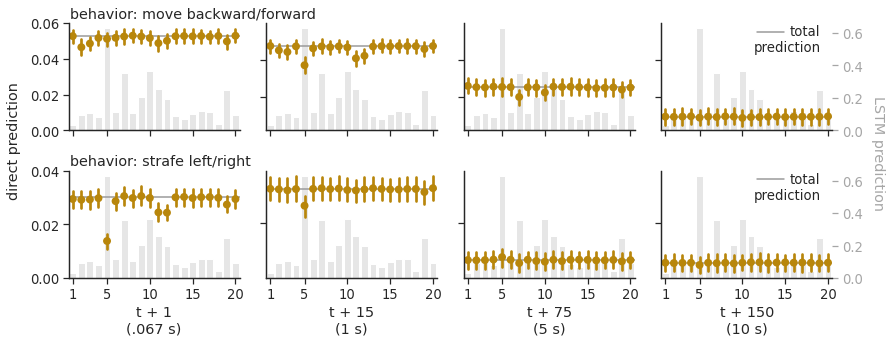

In [889]:
from matplotlib.lines import Line2D

offsets = {1: 1/15, 15: 1, 75: 5, 150: 10}
behaviors = (['move backward/forward'] * 4 +
             ['strafe left/right'] * 4)
grouper = ['behavior', 'PC', 'test map', 'player', 'offset']
offset_labels = ['t + 1\n(.067 s)', 't + 15\n(1 s)',
                 't + 75\n(5 s)', 't + 150\n(10 s)']
M_offset = 1

scores_dfs = []
for offset in offsets:
    Y_offset = M_offset + offset
    scores_df = pd.read_csv(f'results/mediation-behav_Moffset-{M_offset}_'
                            f'Yoffset-{Y_offset}_matchup-{matchup_id}_results.csv')
    scores_df['offset'] = offset
    scores_dfs.append(scores_df)
scores_df = pd.concat(scores_dfs)

sns.set(style='ticks', font_scale=1.2)
fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey='row')

twinaxs = []
for offset, behavior, ax in zip(list(offsets) * 2, behaviors, axs.ravel()):
    scores_dfb = scores_df[scores_df['behavior'] == behavior]#.groupby(
    #    grouper, as_index=False).mean()
    total_score = scores_dfb['total score'][
        (scores_dfb['PC'] < 20) &
        (scores_dfb['offset'] == offset)].mean()
    ax1 = ax.twinx()
    twinaxs.append(ax1)
    sns.barplot(x='PC', y='XM score', ci=None,#errcolor='.8', errwidth=.5,
                data=scores_dfb[(scores_dfb['PC'] < 20) &
                                (scores_dfb['offset'] == offset)],
                color='.9', zorder=0, ax=ax1)
    ax1.set(xlabel=None, ylabel=None, yticks=[])
    ax.axhline(total_score, c='.6', zorder=0)
    sns.pointplot(x='PC', y='direct score',
                  data=scores_dfb[(scores_dfb['PC'] < 20) &
                                  (scores_dfb['offset'] == offset)],
                  color='darkgoldenrod', zorder=1000,
                  join=False, ax=ax, scale=.9)
    ax.set(xlabel=None, ylabel=None)
    ax.set_xticks([0, 4, 9, 14, 19])
    ax.set_xticklabels([1, 5, 10, 15, 20])
    ax.set_zorder(ax1.get_zorder()+1)
    ax.patch.set_visible(False)

axs.ravel()[0].set_yticks([0, .02, .04, .06])
axs.ravel()[4].set_yticks([0, .02, .04])
axs.ravel()[0].set_title(f'behavior: move backward/forward',
             ha='left', va='bottom', x=0.01, y=.97)
axs.ravel()[4].set_title(f'behavior: strafe left/right',
             ha='left', va='bottom', x=0.01, y=.97)
line = Line2D([0], [0], label='total\nprediction', color='.6')
l1 = axs.ravel()[3].legend(handles=[line], loc='upper right',
                           frameon=False, handletextpad=-2.3,
                           bbox_to_anchor=(1, 1.18))
l1.texts[0].set(multialignment='right', y=-8.5)
l2 = axs.ravel()[7].legend(handles=[line], loc='upper right', 
                           frameon=False, handletextpad=-2.3,
                           bbox_to_anchor=(1, 1.18))
l2.texts[0].set(multialignment='right', y=-8.5)

for c, o in enumerate(offset_labels):
    axs[1, c].set(xlabel=o)
twinaxs[3].set(yticks=[0, .2, .4, .6])
twinaxs[3].tick_params(axis='y', colors='.65')
twinaxs[7].set(yticks=[0, .2, .4, .6])
twinaxs[7].tick_params(axis='y', colors='.65')
fig.text(1, 0.4, 'LSTM prediction', c='.65',
         ha='center', rotation=270)
fig.text(0, 0.43, 'direct prediction',
         ha='center', rotation='vertical')
sns.despine()
plt.tight_layout()
plt.savefig(f'figures/mediation-behav_data-v1_bar.svg', dpi=300, bbox_inches='tight', transparent=True)

In [566]:
# Load train/test PCA folds
n_maps = 32
n_repeats = 32
n_players = 4
n_samples = 4501
n_lstms = 512
n_pcs = 142
n_targets = 30

map_id = slice(None)
matchup_id = 0
repeat_id = 0
player_id = slice(None)

offsets = {1: 1/15, 15: 1, 75: 5, 150: 10}

offset_scores = {'autoregressive score': [], 'causal score': [],
                 'behavior': [], 'offset': [], 'test map': [], 'player': []}

for test_map in np.arange(n_maps):
    train_maps = np.array([m for m in np.arange(n_maps) if m != test_map])

    train_repeats = np.tile(np.repeat(np.arange(n_repeats), n_players * n_samples), n_maps - 1)
    test_repeats = np.repeat(np.arange(n_repeats), n_players * n_samples)

    train_shape = ((n_maps - 1) * n_repeats * n_players * n_samples, n_lstms)
    test_shape = (n_repeats * n_players * n_samples, n_lstms)

    assert train_shape[0] == train_repeats.shape[0]
    assert test_shape[0] == test_repeats.shape[0]

    for player_id in np.arange(n_players):
        
        train_X = teammate_behav[train_maps, player_id]
        test_X = teammate_behav[test_map, player_id]
        train_Y = player_behav[train_maps, player_id]
        test_Y = player_behav[test_map, player_id]
        
        # Apply offset lag for "causality" analysis
        for offset in offsets:
            train_future = np.concatenate((train_Y[..., offset:, :],
                        np.zeros((train_Y.shape[:-2] +
                                 (offset,) +
                                 (train_Y.shape[-1],)))), axis=-2)
            test_future = np.concatenate((test_Y[..., offset:, :],
                        np.zeros((test_Y.shape[:-2] +
                                 (offset,) +
                                 (test_Y.shape[-1],)))), axis=-2)

            train_X = train_X.reshape((-1, train_X.shape[-1]))
            test_X = test_X.reshape((-1, test_X.shape[-1]))
            train_Y = train_Y.reshape((-1, train_Y.shape[-1]))
            test_Y = test_Y.reshape((-1, test_Y.shape[-1]))
            train_future = train_future.reshape((-1, train_Y.shape[-1]))
            test_future = test_future.reshape((-1, test_Y.shape[-1]))

            scores = autoreg_encoding(train_X, test_X,
                                      train_Y, test_Y,
                                      train_future, test_future,
                                      scorer=pearsonr)
            scores_auto, scores_causal = scores
            offset_scores['autoregressive score'].extend(scores_auto)
            offset_scores['causal score'].extend(scores_causal)
            offset_scores['offset'].extend([offsets[offset]] * n_targets)
            offset_scores['test map'].extend([test_map] * n_targets)
            offset_scores['behavior'].extend(behav_labels)
            offset_scores['player'].extend([player_id] * n_targets)
    print(f"Finished map {test_map}")
        
scores_df = pd.DataFrame(offset_scores)
scores_df.to_csv(f'results/causal-behav_matchup-{matchup_id}_results.csv', index=False)

Finished map 0
Finished map 1
Finished map 2
Finished map 3
Finished map 4
Finished map 5
Finished map 6
Finished map 7
Finished map 8
Finished map 9
Finished map 10
Finished map 11
Finished map 12
Finished map 13
Finished map 14
Finished map 15
Finished map 16
Finished map 17
Finished map 18
Finished map 19
Finished map 20
Finished map 21
Finished map 22
Finished map 23
Finished map 24
Finished map 25
Finished map 26
Finished map 27
Finished map 28
Finished map 29
Finished map 30
Finished map 31


<AxesSubplot:xlabel='score', ylabel='behavior'>

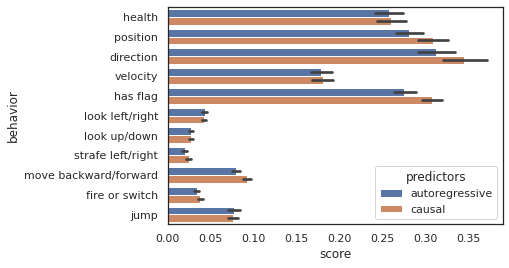

In [274]:
behav_values = ['autoregressive score', 'causal score']
offset = 5

scores_melt = scores_df.melt(
    id_vars=['offset', 'test map', 'player', 'behavior'],
    value_vars=behav_values, var_name='predictors',
    value_name='score')
rename_behav = {b:b.split(' ')[0] for b in behav_values}
scores_melt.replace(to_replace=rename_behav, inplace=True)

sns.barplot(y='behavior', x='score', hue='predictors',
            data=scores_melt[scores_melt['offset'] == offset])

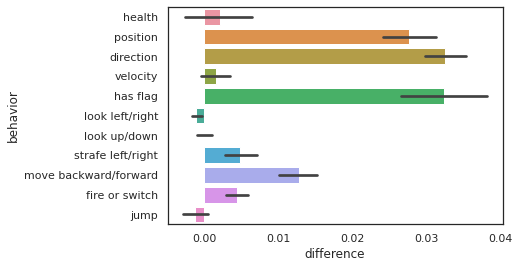

In [273]:
scores_df['difference'] = scores_df['causal score'] - scores_df['autoregressive score']
offset = 5

sns.barplot(y='behavior', x='difference',
            data=scores_df[scores_df['offset'] == offset])
scores_df = scores_df.drop(columns=['difference'])

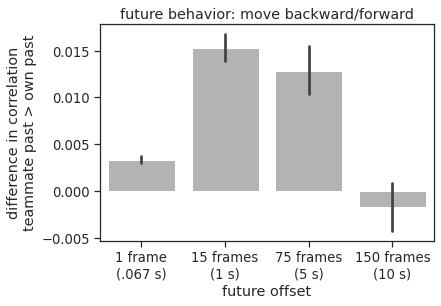

In [572]:
scores_df['difference'] = scores_df['causal score'] - scores_df['autoregressive score']
behavior = 'move backward/forward'
offset_labels = ['1 frame\n(.067 s)', '15 frames\n(1 s)',
                 '75 frames\n(5 s)', '150 frames\n(10 s)']

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='offset', y='difference', color='.7',
            data=scores_df[scores_df['behavior'] == behavior], ax=ax)
ax.set(title=f'future behavior: {behavior}', xlabel='future offset',
       ylabel=('difference in correlation\n' + 
               f'teammate past > own past'))
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(offset_labels)
scores_df = scores_df.drop(columns=['difference'])

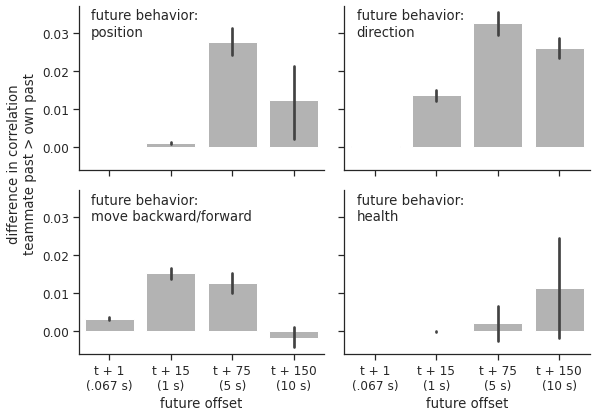

In [406]:
scores_df['difference'] = scores_df['causal score'] - scores_df['autoregressive score']
behavior = 'health'
offset_labels = ['t + 1\n(.067 s)', 't + 15\n(1 s)',
                 't + 75\n(5 s)', 't + 150\n(10 s)']

behav_df = scores_df[(scores_df['behavior'] == 'position') |
                     (scores_df['behavior'] == 'direction') |
                     (scores_df['behavior'] == 'move backward/forward') |
                     (scores_df['behavior'] == 'health')]

behav_labels = ['position', 'direction', 'move backward/forward', 'health']

sns.set(style='ticks', font_scale=1.1)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
for ax, l in zip(axs.ravel(), behav_labels):
    sns.barplot(x='offset', y='difference', color='.7', zorder=0,
                data=scores_df[scores_df['behavior'] == l], ax=ax)
    ax.set(xlabel=None, ylabel=None, ylim=(-.006, .037))
    ax.set_title(f'future behavior:\n{l}',
                 ha='left', va='top', x=.05, y=.95)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(offset_labels)

axs[1, 0].set(xlabel='future offset')
axs[1, 1].set(xlabel='future offset')
fig.text(-.01, 0.4, ('difference in correlation\n' + 
                     f'teammate past > own past'),
         ha='center', rotation='vertical')
plt.tight_layout()
sns.despine()

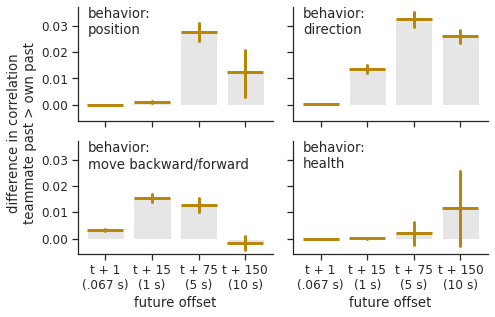

In [890]:
scores_df = pd.read_csv(f'results/causal-behav_matchup-{matchup_id}_results.csv')

scores_df['difference'] = scores_df['causal score'] - scores_df['autoregressive score']
behavior = 'health'
offset_labels = ['t + 1\n(.067 s)', 't + 15\n(1 s)',
                 't + 75\n(5 s)', 't + 150\n(10 s)']

behav_df = scores_df[(scores_df['behavior'] == 'position') |
                     (scores_df['behavior'] == 'direction') |
                     (scores_df['behavior'] == 'move backward/forward') |
                     (scores_df['behavior'] == 'health')]

behav_labels = ['position', 'direction', 'move backward/forward', 'health']

sns.set(style='ticks', font_scale=1.1)
fig, axs = plt.subplots(2, 2, figsize=(6.6, 4.6), sharex=True, sharey=True)
for ax, l in zip(axs.ravel(), behav_labels):
    sns.barplot(x='offset', y='difference', color='.9', zorder=0,
                data=scores_df[scores_df['behavior'] == l], ax=ax,
                errcolor='darkgoldenrod', errwidth=3, saturation=100)
    means = scores_df[scores_df['behavior'] == l].groupby(
        'offset').mean()['difference'].values
    ax.scatter(np.arange(4), means, marker='_',
               c='darkgoldenrod', s=1250, linewidth=3)
    ax.set(xlabel=None, ylabel=None, ylim=(-.006, .037))
    ax.set_title(f'behavior:\n{l}',
                 ha='left', va='top', x=.05, y=.95)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(offset_labels)

axs[1, 0].set(xlabel='future offset', yticks=[0, .01, .02, .03])
axs[1, 1].set(xlabel='future offset', yticks=[0, .01, .02, .03])
fig.text(-.01, 0.31, ('difference in correlation\n' + 
                     f'teammate past > own past'),
         ha='center', rotation='vertical')
plt.tight_layout()
sns.despine()
plt.savefig(f'figures/causal-behav_data-v1_bar.svg', dpi=300, bbox_inches='tight', transparent=True)